In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("Datasheet for fieldwork_Combined_Group 1.xlsx", header=1)

df = df.rename(
    columns={
        "Tree #": "tree_id",
        "Species (latin name)": "species",
        "Plot (mixed vs. mono)": "plot_type",
        "DBH (in cm)": "dbh",
        "Height (in m)": "height",
        "Aboveground biomass (in kg)": "agb",
        "LAI (m²/m²)": "lai",
        "Shannon index": "shannon",
        "Soil pH": "soil_pH",
        "IBP": "ibp",
        "Group": "group",
    }
)

df = df.loc[
    (~df["species"].str.contains(r"\(mort\)", case=False, na=False))
    & (~df["species"].str.contains(r" mort", case=False, na=False))
].reset_index(drop=True)

In [3]:
df["species"].unique()

array(['Picea Abies', 'Fagus Sylvatica', 'Abies Alba', 'Quercus Robur',
       'Castanea Sativa', 'Picea', 'Alnus Glutanosa', 'Sambucus Racemosa',
       'Corylus Avellana', 'Quercus Petraea', 'Castanea Dentata',
       'Pinus Sylvestris', 'Castanea sativa'], dtype=object)

In [4]:
# Unify species name
df.loc[df["species"]=="Picea", "species"] = "Picea Abies"  
df.loc[df["species"]=="Castanea sativa", "species"] = "Castanea Sativa"
df["species"].unique()

array(['Picea Abies', 'Fagus Sylvatica', 'Abies Alba', 'Quercus Robur',
       'Castanea Sativa', 'Alnus Glutanosa', 'Sambucus Racemosa',
       'Corylus Avellana', 'Quercus Petraea', 'Castanea Dentata',
       'Pinus Sylvestris'], dtype=object)

In [5]:
# split dataframe by plot type
df_mixed = df[df["plot_type"] == "Mixed"]
df_mono = df[df["plot_type"] == "Mono"]

# Descriptive Statistics

In [6]:
df.describe()

,tree_id,dbh,height,agb,lai,shannon,soil_pH,ibp,group
count,206.000000,191.000000,206.000000,191.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,104.228155,20.078208,13.635874,634.679856,5.026650,0.745124,4.979126,21.436893,4.970874
std,60.569987,16.624011,10.631826,2635.663825,1.634132,0.391288,0.294932,11.408743,2.684940
min,1.000000,0.808507,1.400000,0.033459,1.420000,0.000000,4.120000,8.000000,1.000000
25%,52.250000,4.451564,3.085000,4.569563,4.180000,0.500402,4.860000,11.000000,3.000000
50%,103.500000,16.233804,11.350000,61.290000,5.260000,0.759547,5.070000,22.000000,5.000000
75%,156.750000,32.945073,22.000000,481.029872,6.530000,1.060000,5.200000,26.000000,7.000000
max,209.000000,66.800000,40.000000,28195.001960,6.900000,1.520000,5.670000,42.000000,10.000000


In [7]:
df.groupby("species").agg(count=("tree_id", "count"))

,count
species,
Abies Alba,52
Alnus Glutanosa,1
Castanea Dentata,2
Castanea Sativa,5
Corylus Avellana,4
Fagus Sylvatica,56
Picea Abies,73
Pinus Sylvestris,8
Quercus Petraea,1


In [8]:
df.groupby("plot_type").agg(species_count=("species", "nunique"))

,species_count
plot_type,
Mixed,6
Mono,9


In [9]:
df.groupby(["plot_type", "group"]).agg(species_count=("species", "nunique"))

species_count
plot_type group               
Mixed     1                  4
          2                  3
          3                  4
          4                  3
          5                  3
          6                  2
          7                  4
          8                  3
          10                 3
Mono      1                  1
          2                  1
          3                  3
          4                  2
          5                  2
          6                  3
          7                  3
          8                  2
          10                 4

In [10]:
df.groupby(["plot_type", "species"]).agg(count=("tree_id", "count")).sort_values(by=["plot_type", "count"], ascending=False)

count
plot_type species                 
Mono      Picea Abies           31
          Abies Alba            28
          Fagus Sylvatica        9
          Pinus Sylvestris       8
          Corylus Avellana       4
          Castanea Sativa        3
          Castanea Dentata       2
          Alnus Glutanosa        1
          Sambucus Racemosa      1
Mixed     Fagus Sylvatica       47
          Picea Abies           42
          Abies Alba            24
          Quercus Robur          3
          Castanea Sativa        2
          Quercus Petraea        1

### tree-level metrics comparison between plots

In [11]:
df.groupby("plot_type")[["dbh", "height", "agb"]].agg(["mean", "var"])
# there are extreme values in agb, so the variance is very high

dbh                 height                     agb  \
                mean         var       mean         var        mean   
plot_type                                                             
Mixed      16.376549  291.513268   9.849328   74.870905  769.903911   
Mono       24.597675  223.473544  18.815172  119.739049  469.580719   

                         
                    var  
plot_type                
Mixed      1.234762e+07  
Mono       3.701267e+05

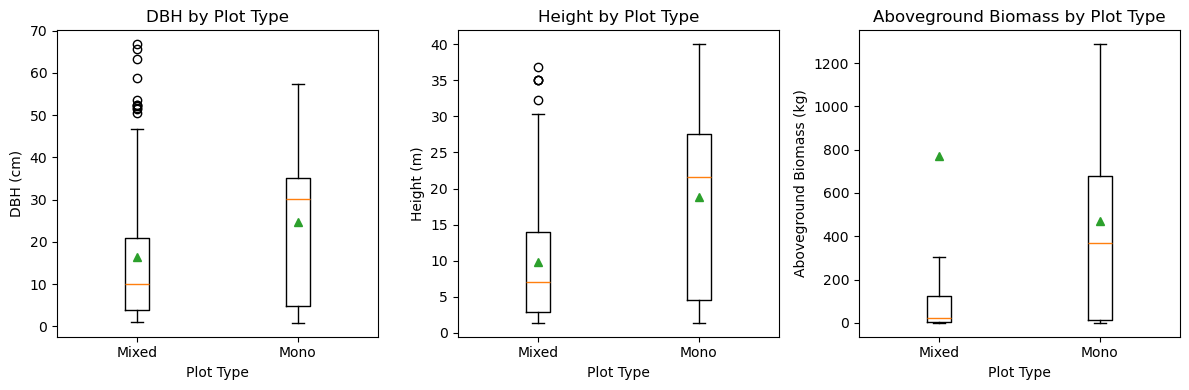

In [12]:
# tree-level metrics comparison between plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

axes[0].boxplot([
    df.groupby("plot_type")["dbh"].get_group("Mixed").dropna().values,
    df.groupby("plot_type")["dbh"].get_group("Mono").dropna().values
], labels=["Mixed", "Mono"], showmeans=True)
axes[0].set_title("DBH by Plot Type")
axes[0].set_xlabel("Plot Type")
axes[0].set_ylabel("DBH (cm)")

axes[1].boxplot([
    df.groupby("plot_type")["height"].get_group("Mixed").dropna().values,
    df.groupby("plot_type")["height"].get_group("Mono").dropna().values
], labels=["Mixed", "Mono"], showmeans=True)
axes[1].set_title("Height by Plot Type")
axes[1].set_xlabel("Plot Type")
axes[1].set_ylabel("Height (m)")

axes[2].boxplot([
    df.groupby("plot_type")["agb"].get_group("Mixed").dropna().values,
    df.groupby("plot_type")["agb"].get_group("Mono").dropna().values
], labels=["Mixed", "Mono"], showfliers=False, showmeans=True)
# exclude outliers for better visualization
axes[2].set_title("Aboveground Biomass by Plot Type")
axes[2].set_xlabel("Plot Type")
axes[2].set_ylabel("Aboveground Biomass (kg)")

plt.subplots_adjust(left=0.08, wspace=0.4)
plt.tight_layout()
plt.show()

### plot-level metrics comparison between plots

In [13]:
df.groupby("plot_type")[["lai", "shannon", "soil_pH", "ibp"]].agg(["unique"]).applymap(
    lambda x: (
        {"mean": round(float(np.mean(x)), 2), "var": round(float(np.var(x, ddof=1)), 2)}
        if isinstance(x, (list, np.ndarray)) and len(x) > 0
        else np.nan
    )
)

C:\Users\liyou\AppData\Local\Temp\ipykernel_4120\130685882.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.groupby("plot_type")[["lai", "shannon", "soil_pH", "ibp"]].agg(["unique"]).applymap(


,lai,shannon,soil_pH,ibp
,unique,unique,unique,unique
plot_type,,,,
Mixed,"{'mean': 5.43, 'var': 3.29}","{'mean': 0.92, 'var': 0.1}","{'mean': 5.01, 'var': 0.05}","{'mean': 27.71, 'var': 118.9}"
Mono,"{'mean': 4.54, 'var': 1.11}","{'mean': 0.67, 'var': 0.23}","{'mean': 4.98, 'var': 0.22}","{'mean': 13.83, 'var': 23.37}"


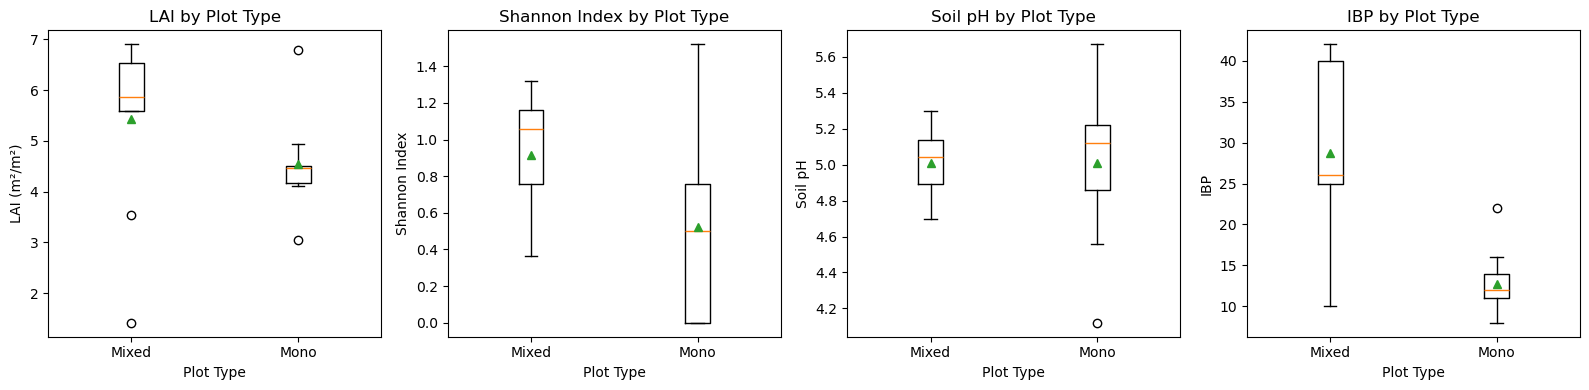

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4)) 

axes[0].boxplot([
    df.groupby(["plot_type", "group"])["lai"].unique().xs("Mixed", level="plot_type"),
    df.groupby(["plot_type", "group"])["lai"].unique().xs("Mono", level="plot_type"),
], labels=["Mixed", "Mono"], showmeans=True)
axes[0].set_title("LAI by Plot Type")
axes[0].set_xlabel("Plot Type")
axes[0].set_ylabel("LAI (m²/m²)")

axes[1].boxplot([
    df.groupby(["plot_type", "group"])["shannon"].unique().xs("Mixed", level="plot_type"),
    df.groupby(["plot_type", "group"])["shannon"].unique().xs("Mono", level="plot_type"),
], labels=["Mixed", "Mono"], showmeans=True)
axes[1].set_title("Shannon Index by Plot Type")
axes[1].set_xlabel("Plot Type")
axes[1].set_ylabel("Shannon Index")

axes[2].boxplot([
    df.groupby(["plot_type", "group"])["soil_pH"].unique().xs("Mixed", level="plot_type"),
    df.groupby(["plot_type", "group"])["soil_pH"].unique().xs("Mono", level="plot_type"),
], labels=["Mixed", "Mono"], showmeans=True)
axes[2].set_title("Soil pH by Plot Type")
axes[2].set_xlabel("Plot Type")
axes[2].set_ylabel("Soil pH")

axes[3].boxplot([
    df.groupby(["plot_type", "group"])["ibp"].unique().xs("Mixed", level="plot_type"),
    df.groupby(["plot_type", "group"])["ibp"].unique().xs("Mono", level="plot_type"),
], labels=["Mixed", "Mono"], showmeans=True)
axes[3].set_title("IBP by Plot Type")
axes[3].set_xlabel("Plot Type")
axes[3].set_ylabel("IBP")

plt.subplots_adjust(left=0.05, wspace=0.4)
plt.tight_layout()
plt.show()

### tree-level metrics comparison between the 3 most common species

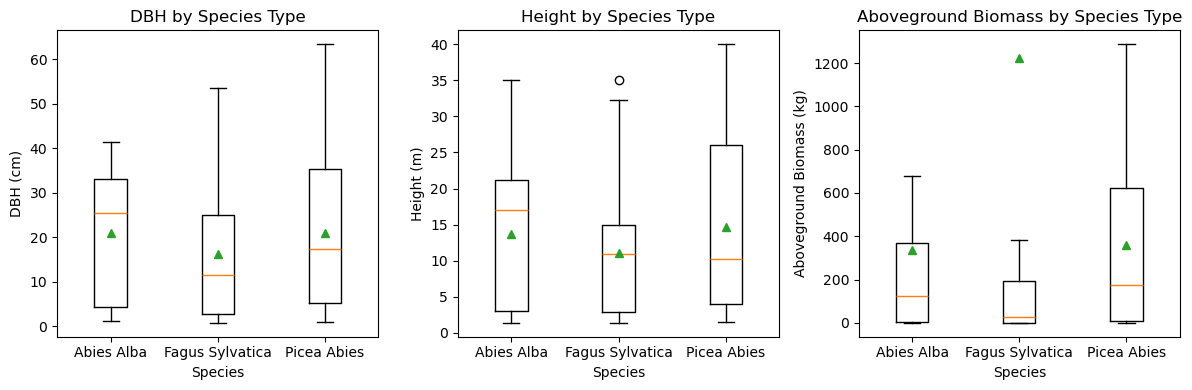

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

axes[0].boxplot([
    df.groupby("species")["dbh"].get_group("Abies Alba").dropna().values,
    df.groupby("species")["dbh"].get_group("Fagus Sylvatica").dropna().values,
    df.groupby("species")["dbh"].get_group("Picea Abies").dropna().values,
], labels=["Abies Alba", "Fagus Sylvatica", "Picea Abies"], showmeans=True)
axes[0].set_title("DBH by Species Type")
axes[0].set_xlabel("Species")
axes[0].set_ylabel("DBH (cm)")

axes[1].boxplot([
    df.groupby("species")["height"].get_group("Abies Alba").dropna().values,
    df.groupby("species")["height"].get_group("Fagus Sylvatica").dropna().values,
    df.groupby("species")["height"].get_group("Picea Abies").dropna().values,
], labels=["Abies Alba", "Fagus Sylvatica", "Picea Abies"], showmeans=True)
axes[1].set_title("Height by Species Type")
axes[1].set_xlabel("Species")
axes[1].set_ylabel("Height (m)")

axes[2].boxplot([
    df.groupby("species")["agb"].get_group("Abies Alba").dropna().values,
    df.groupby("species")["agb"].get_group("Fagus Sylvatica").dropna().values,
    df.groupby("species")["agb"].get_group("Picea Abies").dropna().values,
], labels=["Abies Alba", "Fagus Sylvatica", "Picea Abies"], showfliers=False, showmeans=True)
# exclude outliers for better visualization
axes[2].set_title("Aboveground Biomass by Species Type")
axes[2].set_xlabel("Species")
axes[2].set_ylabel("Aboveground Biomass (kg)")

plt.subplots_adjust(left=0.08, wspace=0.4)
plt.tight_layout()
plt.show()

# Group Comparisons